<a href="https://colab.research.google.com/github/lingyixu/CS523-Deep-Learning/blob/main/Non_Graph_NN/MLP_Multiclass_Classification_5Fold_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load packages

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 64.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
# import torch_geometric
# from torch_geometric.data import Dataset, Data
# from torch_geometric.nn import GCNConv, GATConv
# from torch_geometric.transforms import RandomNodeSplit

In [3]:
import pandas as pd
import numpy as np
import json
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Mounted at /content/drive


### Load dataset: LastFM

In [5]:
df_feat = pd.read_json(drive_path + 'processed_feature.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of users: {num_nodes}')
print(f'Number of features: {num_features}')
# print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of users: 7624
Number of features: 7842
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


### Create Dataset

In [6]:
class LastFM(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        data = self.x[index,]
        if self.transform is not None:
            data = self.transform(data)
        if self.y is not None:
            return data, self.y[index]
        else:
            return data

In [7]:
def dataset_split(n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_ids = []
    test_ids = []

    for train_index, test_index in splits.split(X):
        train_ids.append(list(train_index))
        test_ids.append(list(test_index))

    return train_ids, test_ids

In [8]:
n_fold = 5
train_ids, test_ids = dataset_split(n_fold)

for i in range(n_fold):
    print('================')
    print(f'Fold {i+1}:')
    print(f'Train data: {len(train_ids[i])}')
    print(f'Test data: {len(test_ids[i])}')

Fold 1:
Train data: 6099
Test data: 1525
Fold 2:
Train data: 6099
Test data: 1525
Fold 3:
Train data: 6099
Test data: 1525
Fold 4:
Train data: 6099
Test data: 1525
Fold 5:
Train data: 6100
Test data: 1524


In [9]:
train_sets = []
test_sets = []

for i in range(n_fold):
    train_sets.append(LastFM(x=arr_feat[train_ids[i]], y=arr_tar[train_ids[i]]))
    test_sets.append(LastFM(x=arr_feat[test_ids[i]], y=arr_tar[test_ids[i]]))

### Build Model

In [10]:
# ref: https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp/notebook
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super().__init__()
        # torch.manual_seed(42)
        self.lin1 = nn.Linear(num_features, hidden_channels1)
        self.lin2 = nn.Linear(hidden_channels1, hidden_channels2)
        self.lin3 = nn.Linear(hidden_channels2, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.1)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.1)
        x = self.lin3(x)
        return x

In [11]:
criterion = torch.nn.CrossEntropyLoss()

### Model training and testing

In [12]:
# set params
hidden_channels1 = 4096
hidden_channels2 = 4096
lr = 5e-4
weight_decay = 5e-4
epoch = 100
save_results = False

In [19]:
def train(model, train_set):
      model.train()
      optimizer.zero_grad()
      out = model(train_set.x.to(device))
      loss = criterion(out, train_set.y.flatten().to(device))
      loss.backward()
      optimizer.step()
      # return loss

def test(model, test_set):
      model.eval()
      out = model(test_set.x.to(device))
      loss = criterion(out, test_set.y.flatten().to(device)).cpu().detach().item()
      pred = out.argmax(dim=1)
      correct = pred == test_set.y.flatten().to(device)
      acc = correct.sum() / len(test_set)
      return loss, acc.cpu().detach().item()

In [20]:
# cross validation
train_acc_all = []
test_acc_all = []
train_loss_all = []
test_loss_all = []

for i in range(n_fold):   # loop through folds

    print(f'===== Fold {i+1} ======')
    
    # initialize model and optimizer
    model = MLP(hidden_channels1, hidden_channels2)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # accuracy per epoch
    train_acc_epoch = []
    test_acc_epoch = []
    # loss per epoch
    train_loss_epoch = []
    test_loss_epoch = []

    for e in range(epoch):   # loop through epochs
        
        train(model, train_sets[i])
        train_loss, train_acc = test(model, train_sets[i])
        test_loss, test_acc = test(model, test_sets[i])
        
        # save loss and accuracy history
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
                
        # save model and output
        if (e == epoch-1) and (save_results==True):
            torch.save(model, f'/content/drive/Shareddrives/CS523/Notebooks/model/MLP/fold_{i+1}.pt')
            # torch.save(out, f'/content/drive/Shareddrives/CS523/Notebooks/output/MLP/fold_{i+1}.pt')

        print(f'Epoch: {e+1:02d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

        torch.cuda.empty_cache()

    train_acc_all.append(train_acc_epoch)
    test_acc_all.append(test_acc_epoch)
    train_loss_all.append(train_loss_epoch)
    test_loss_all.append(test_loss_epoch)

===== Fold 1 ======
Epoch: 01, Train loss: 2.3814, Test loss: 2.3718
Epoch: 02, Train loss: 2.1711, Test loss: 2.1843
Epoch: 03, Train loss: 2.0316, Test loss: 2.0724
Epoch: 04, Train loss: 1.8137, Test loss: 1.8762
Epoch: 05, Train loss: 1.6148, Test loss: 1.7007
Epoch: 06, Train loss: 1.5228, Test loss: 1.6505
Epoch: 07, Train loss: 1.3333, Test loss: 1.4811
Epoch: 08, Train loss: 1.2616, Test loss: 1.4514
Epoch: 09, Train loss: 1.1385, Test loss: 1.3692
Epoch: 10, Train loss: 1.0347, Test loss: 1.3071
Epoch: 11, Train loss: 0.9472, Test loss: 1.2652
Epoch: 12, Train loss: 0.8617, Test loss: 1.2075
Epoch: 13, Train loss: 0.7924, Test loss: 1.1753
Epoch: 14, Train loss: 0.7165, Test loss: 1.1290
Epoch: 15, Train loss: 0.6467, Test loss: 1.0863
Epoch: 16, Train loss: 0.5906, Test loss: 1.0656
Epoch: 17, Train loss: 0.5236, Test loss: 1.0407
Epoch: 18, Train loss: 0.4731, Test loss: 1.0363
Epoch: 19, Train loss: 0.4310, Test loss: 1.0509
Epoch: 20, Train loss: 0.3849, Test loss: 1.0295


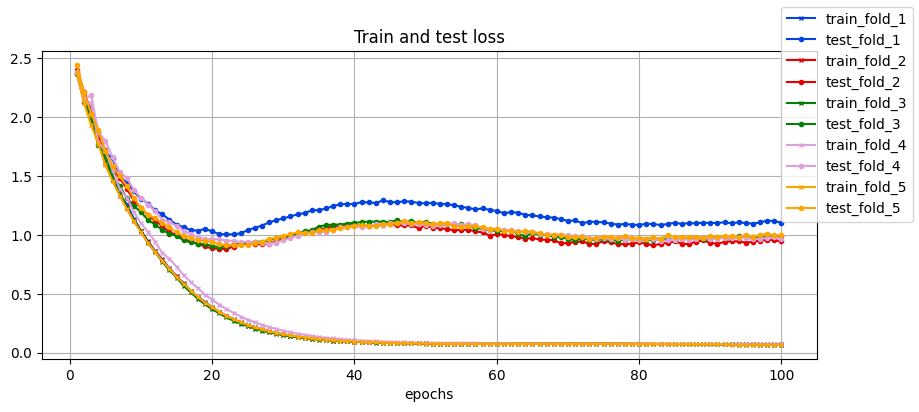

In [27]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(10,4))
colors = ['#0343DF', '#E50000', '#008000', '#DDA0DD', '#FFA500']
for i in range(n_fold):
    ax.plot(range(1,len(train_loss_all[i])+1), train_loss_all[i], '-x', markersize=3, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_loss_all[i])+1), test_loss_all[i], '-o', markersize=3, label=f'test_fold_{i+1}', color=colors[i])
# ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test loss')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

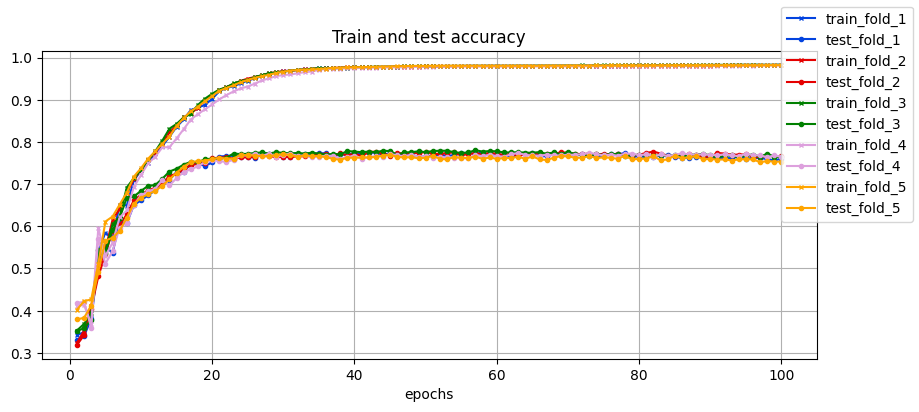

In [29]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(10,4))
for i in range(n_fold):
    ax.plot(range(1,len(train_acc_all[i])+1), train_acc_all[i], '-x', markersize=3, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_acc_all[i])+1), test_acc_all[i], '-o', markersize=3, label=f'test_fold_{i+1}', color=colors[i])
# ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test accuracy')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

In [30]:
# print out average accuracy
acc_list = []
for i in range(n_fold):
    acc = test_acc_all[i][-1]
    acc_list.append(acc)
    print(f'Fold {i+1} test accuracy: {acc:.4f}')
print(f'Average accuracy: {np.mean(acc_list):.4f}')

Fold 1 test accuracy: 0.7607
Fold 2 test accuracy: 0.7659
Fold 3 test accuracy: 0.7646
Fold 4 test accuracy: 0.7652
Fold 5 test accuracy: 0.7533
Average accuracy: 0.7619
